<a href="https://colab.research.google.com/github/DesiPilla/MLTSA_DPilla/blob/master/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



In [1]:
import pandas as pd
import pylab as plt
from pydlm import dlm, trend, seasonality
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [2]:
!pip install fbprophet

In [0]:
import fbprophet

In [0]:
from fbprophet import Prophet
from fbprophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [5]:
a = []
for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
    fname = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-%s14.csv' % mon
    print(fname)
    a.append(pd.read_csv(fname))

https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-may14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jul14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-aug14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-sep14.csv


In [6]:
uberrides = pd.concat(a)
uberrides.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [0]:
uberrides["time"] = pd.to_datetime(uberrides["Date/Time"])

In [8]:
uberbyday = uberrides.groupby(uberrides["time"].dt.date).count()
uberbyday.drop(columns = ["time", "Lat", "Lon", "Base"], inplace=True)
uberbyday.reset_index(inplace=True)
uberbyday.rename(columns={"time":"ds", "Date/Time":"y"}, inplace=True)
uberbyday.head()

,ds,y
0,2014-04-01,14546
1,2014-04-02,17474
2,2014-04-03,20701
3,2014-04-04,26714
4,2014-04-05,19521


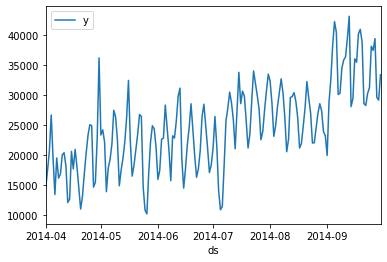

In [9]:
uberbyday.plot(x="ds", y="y");

**Figure 1:** This shows a time series plot of the number of uber rides each day from April 2014 through September 2014. This plot shows the the general number of rides per day has increased over time, but that the exact number varies greatly from day to day.

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

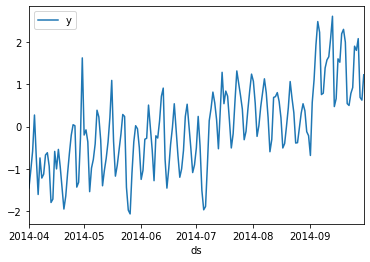

In [85]:
uberbyday["y"] = (uberbyday["y"] - uberbyday["y"].mean()) / uberbyday["y"].std()
uberbyday.plot(x="ds", y="y");

**Figure 2:** This shows a time series plot of the *standardized* number of uber rides each day from April 2014 through September 2014. This plot shows the the general number of rides per day has increased over time, but that the exact number varies greatly from day to day. This is the *standardized* data, which means the overall mean is 0 and the standard deviation is 1.

# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [10]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future = simplem.make_future_dataframe(periods=30, freq="D", )
forecast = simplem.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
208,2014-10-26,31134.715124,26373.865931,35690.921753
209,2014-10-27,33130.919270,28233.041289,37426.408345
210,2014-10-28,37205.142924,32375.184520,41671.101335
211,2014-10-29,39792.996755,34984.561695,44237.106661
212,2014-10-30,42073.407521,37247.434163,46641.088528


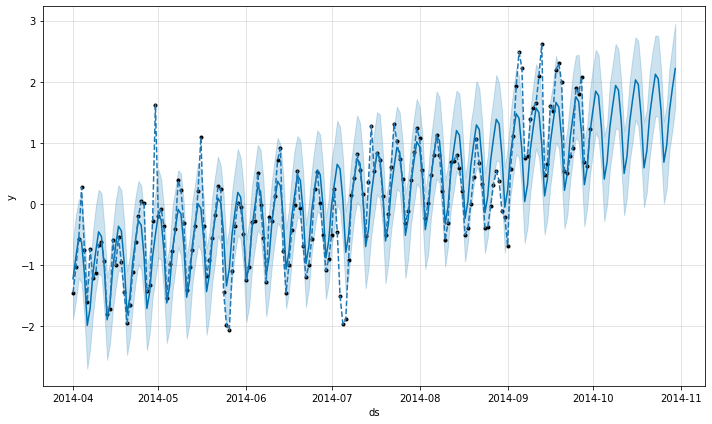

In [234]:
fig1 = simplem.plot(forecast)
plt.plot(uberbyday.ds, uberbyday.y, '--');

**Figure 3:** This shows a time series plot of the *standardized* number of uber rides each day from April 2014 through September 2014, as well as the `Prophet()` forecast for November 2014. The shaded region covers the uncertainty in the forecast prediction. The forecast calls for a continued cyclic motion and general increase in ride count.

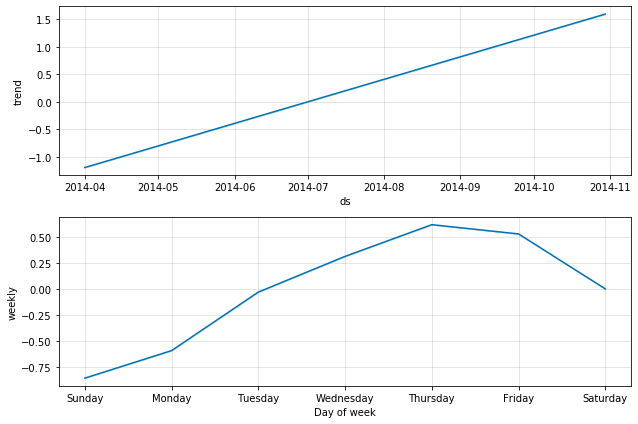

In [235]:
fig2 = simplem.plot_components(forecast)

**Figure 4:** These plots show trends in the number of rides per day. The first plot shows the average number of rides per month; there has been a linear increase each month throughout this range. The second plot shows the average number of rides per day throughout the week; it would appear the the average number of rides increases each day throughout the work week, peaking on Thursday and decreasing through the weekend.

# DATA ANALYSIS: model validatoin
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [12]:
cvresult_simplem = diagnostics.cross_validation(simplem, horizon="30 days")

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [13]:
def rchi2(y, ytrue):
    return ((y - ytrue)**2).sum() / len(y)

print("Reduced chi-square: {:.4f}".format(rchi2(cvresult_simplem.yhat, cvresult_simplem.y)))

Reduced chi-square: 23072399.3171


# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [14]:
!pip install wwo_hist

In [0]:
from wwo_hist import retrieve_hist_data

In [16]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [19]:
frequency = 24 #frequency in hours
start_date = uberbyday.ds[0]
end_date = uberbyday.ds[len(uberbyday) - 1]
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:00.980047
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:01.981910
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:02.962595
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:04.018772
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:05.010398
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:05.937730
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:06.680211


export New+york,ny completed!




In [20]:
# Read in data
weather = pd.read_csv("New+york,ny.csv")
weather[["date_time", "tempC", "precipMM"]].head()

# Convert date_time column to a datetime object
weather["date_time"] = pd.to_datetime(weather["date_time"]).dt.date

# Standardize the data
weather[["tempC", "precipMM"]] = (weather[["tempC", "precipMM"]] - weather[["tempC", "precipMM"]].mean(axis=0)) / weather[["tempC", "precipMM"]].std(axis=0)

# Merge datasets
uberweather = uberbyday.merge(weather, how="left", left_on="ds", right_on="date_time")[["y", "ds", "tempC", "precipMM"]]
uberweather.head()

,y,ds,tempC,precipMM
0,14546,2014-04-01,-1.959822,-0.484962
1,17474,2014-04-02,-1.959822,-0.430609
2,20701,2014-04-03,-1.766830,-0.484962
3,26714,2014-04-04,-3.117776,0.737969
4,19521,2014-04-05,-2.345807,-0.457786


In [0]:
#leave
uberweather

,y,ds,tempC,precipMM
2014-04-01,-1.521465,2014-04-01,-1.959822,-0.484962
2014-04-02,-1.136392,2014-04-02,-1.959822,-0.430609
2014-04-03,-0.711997,2014-04-03,-1.766830,-0.484962
2014-04-04,0.078797,2014-04-04,-3.117776,0.737969
2014-04-05,-0.867183,2014-04-05,-2.345807,-0.457786
...,...,...,...,...
2014-09-28,0.465711,2014-09-28,0.742069,-0.484962
2014-09-29,0.405872,2014-09-29,0.356084,-0.457786
2014-09-29,0.405872,2014-09-29,0.356084,-0.457786
2014-09-30,0.962176,2014-09-30,-0.222892,-0.267552


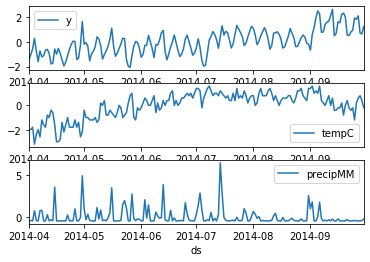

In [213]:
fig, ax = plt.subplots(3)
for i, y in enumerate(["y", "tempC", "precipMM"]):
    uberweather.plot(x="ds", y=y, ax=ax[i])

**Figure 5:** These plots show the number of rides, temperature (in degrees C), and precipitation (in mm) over the specified time range. The temperature plot appears to rise during the summer months and then cool during the fall months. The Precipitation is very scattered and contains mostly events, not trends.

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [21]:
regrm = Prophet()
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM')
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


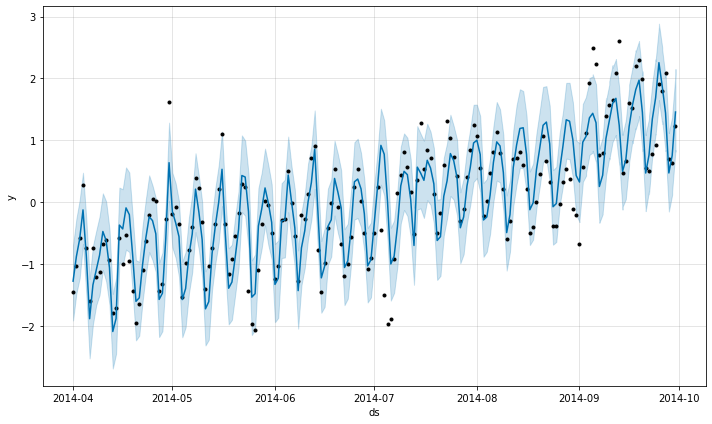

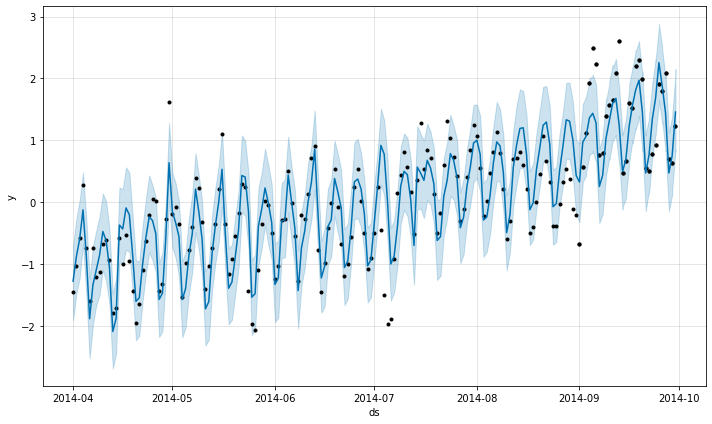

In [238]:
nowcast2 = regrm.predict(uberweather)
simplem.plot(nowcast2)
regrm.plot(nowcast2);

**Figure 6:** These plots show the historic number of rides per day as well as the model fit (and its confidence range). The first plot only uses the historic ride data, while the second plot also uses the historic temperature and preciptation amounts. With the naked eye, the models are not very distinguishable.

In [22]:
cvresult_regrm = diagnostics.cross_validation(regrm, horizon="30 days")

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [224]:
print("Model 1 reduced chi-square: {:.4f}".format(rchi2(cvresult_simplem.yhat, cvresult_simplem.y)))
print("Model 2 reduced chi-square: {:.4f}".format(rchi2(cvresult_regrm.yhat, cvresult_regrm.y)))

Model 1 reduced chi-square: 0.4602
Model 2 reduced chi-square: 0.5298


The more complex model (Model 2) has a slightly better fit than the simpler model (Model 1).

# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [23]:
# Create model
regholm = Prophet()

# Add regressors
regholm.add_regressor('tempC')
regholm.add_regressor('precipMM')
regholm.add_country_holidays(country_name="US")

# Fit model
regholm.fit(uberweather)
nowcast3 = regholm.predict(uberweather);

# Plot models
simplem.plot(nowcast2)
regrm.plot(nowcast2)
regholm.plot(nowcast3);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NameError: ignored

**Figure 7:** These plots show the historic number of rides per day as well as the model fit (and its confidence range). The first plot only uses the historic ride data. The second plot also uses the historic temperature and preciptation amounts. The third plot also adds US holidays to the model. The model that utilizes holidays does a better job predicting the abnormal spikes in ride usage.

In [0]:
cvresult_regholm = diagnostics.cross_validation(regholm, horizon="30 days")

In [248]:
print("Model 1 reduced chi-square: {:.4f}".format(rchi2(cvresult_simplem.yhat, cvresult_simplem.y)))
print("Model 2 reduced chi-square: {:.4f}".format(rchi2(cvresult_regrm.yhat, cvresult_regrm.y)))
print("Model 3 reduced chi-square: {:.4f}".format(rchi2(cvresult_regholm.yhat, cvresult_regholm.y)))

Model 1 reduced chi-square: 0.4602
Model 2 reduced chi-square: 0.5298
Model 3 reduced chi-square: 0.4371


The most complex model had a lower reduced chi-square value. This could be attributed to overfitting at times.

# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


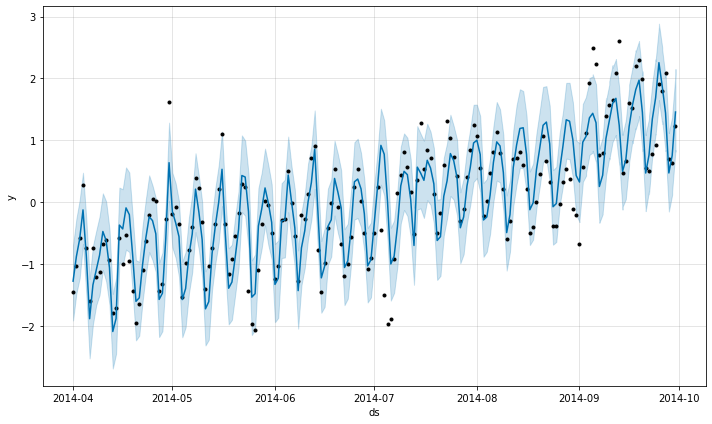

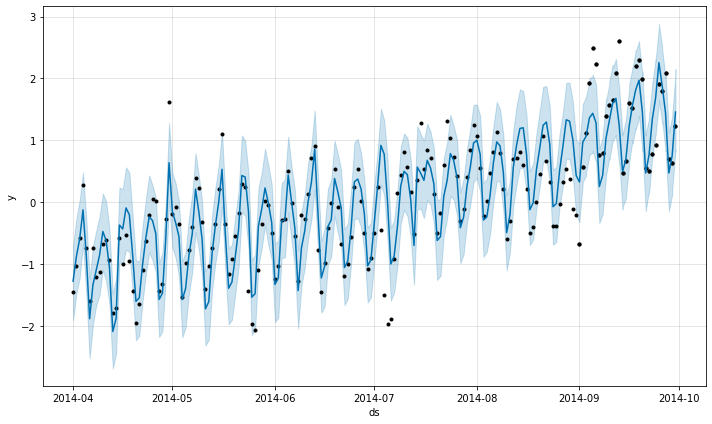

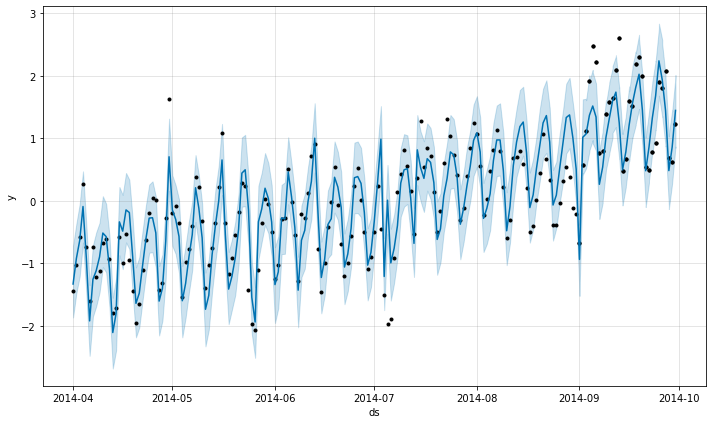

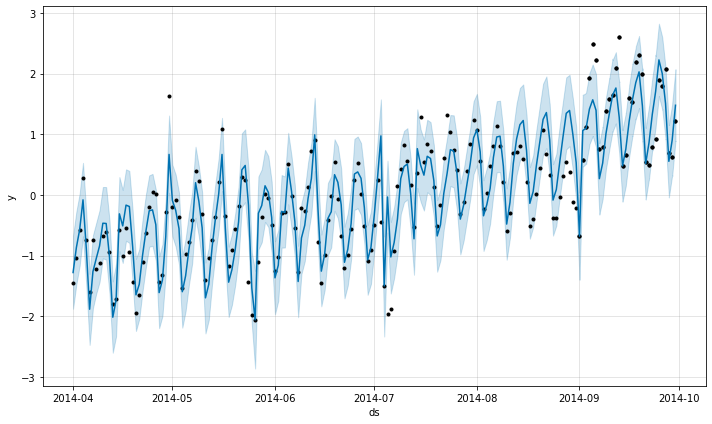

In [251]:
# Create model
regmcmc = Prophet(mcmc_samples=5000)

# Add regressors
regmcmc.add_regressor('tempC')
regmcmc.add_regressor('precipMM')
regmcmc.add_country_holidays(country_name="US")

# Fit model
regmcmc.fit(uberweather)
nowcast4 = regmcmc.predict(uberweather);

# Plot models
simplem.plot(nowcast2)
regrm.plot(nowcast2)
regholm.plot(nowcast3);
regmcmc.plot(nowcast4);

In [252]:
cvresult_regmcmc = diagnostics.cross_validation(regmcmc, horizon="30 days")

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [253]:
print("Model 1 reduced chi-square: {:.4f}".format(rchi2(cvresult_simplem.yhat, cvresult_simplem.y)))
print("Model 2 reduced chi-square: {:.4f}".format(rchi2(cvresult_regrm.yhat, cvresult_regrm.y)))
print("Model 3 reduced chi-square: {:.4f}".format(rchi2(cvresult_regholm.yhat, cvresult_regholm.y)))
print("Model 4 reduced chi-square: {:.4f}".format(rchi2(cvresult_regmcmc.yhat, cvresult_regmcmc.y)))

Model 1 reduced chi-square: 0.4602
Model 2 reduced chi-square: 0.5298
Model 3 reduced chi-square: 0.4371
Model 4 reduced chi-square: 0.5014


The MCMC implementation (Model 4) had an improved reduced chi-square compared to the MAPE implementation (Model 3).

# Extra Credit
There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm

In [32]:
!pip install pydlm

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for pydlm: filename=pydlm-0.1.1.11-py2.py3-none-any.whl size=58997 sha256=f288d25be55f0e04d84ef2c57c450dadbb4eb3cfd37003d58a151af288899d7d
  Stored in directory: /root/.cache/pip/wheels/69/d3/ca/f5a7bc0976a2779bf87c20f82a9adece40616ee3b9d39bf410
Successfully built pydlm
